***Dataset from: http://insideairbnb.com/get-the-data.html***
        
***I choose Barcelona.***

In [730]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
import re
from datetime import datetime
func = "../Function/"
sys.path.append(func)
from py_helper_functions import *

import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_squared_error

from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.tree import DecisionTreeClassifier
from mizani.formatters import percent_format
from plotnine import *
import matplotlib.pyplot as plt
from plotnine import *


from skranger.ensemble import RangerForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

***Import the data which I want to used.***

In [617]:
bcn = pd.read_csv('../Data/listings.csv')

In [619]:
bcn["property_type"].value_counts()

Entire rental unit                     7519
Private room in rental unit            5768
Entire serviced apartment               411
Entire loft                             279
Room in boutique hotel                  262
Entire condominium (condo)              260
Private room in condominium (condo)     242
Private room in residential home        222
Private room in hostel                  137
Room in hotel                           134
Private room in serviced apartment      129
Shared room in hostel                    90
Private room in bed and breakfast        83
Private room in guest suite              78
Entire residential home                  65
Room in hostel                           59
Private room in loft                     58
Shared room in rental unit               57
Entire guest suite                       40
Room in serviced apartment               32
Boat                                     28
Private room in casa particular          28
Private room                    

***keep the target property type***

In [620]:
bcn = bcn.loc[lambda x: x["property_type"].isin(["Entire rental unit", 
                                                 "Private room in rental unit", 
                                                 "Entire serviced apartment", 
                                                 "Entire loft", 
                                                 "Room in boutique hotel", 
                                                 "Entire condominium (condo)", 
                                                 "Private room in condominium (condo)", 
                                                 "Private room in residential home", 
                                                 "Private room in hostel", 
                                                 "Room in hotel", 
                                                 "Private room in serviced apartment",
                                                 "Shared room in hostel",
                                                 "Entire residential home", 
                                                 "Room in hostel",
                                                 "Private room in loft",
                                                 "Shared room in rental unit"
                                                ])]

***Re-classify the property type***

In [621]:
bcn["property_type"] = np.where(
    bcn["property_type"] == "Private room in rental unit", 
    "Entire rental unit", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Entire loft", 
    "Entire serviced apartment", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Room in boutique hotel", 
    "Room in hotel", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Entire condominium (condo)", 
    "Entire serviced apartment", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Private room in condominium (condo)", 
    "Entire serviced apartment", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Private room in residential home", 
    "Entire serviced apartment", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Private room in hostel", 
    "Room in hotel", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Private room in serviced apartment", 
    "Entire serviced apartment", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Shared room in hostel", 
    "Room in hotel", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Entire residential home", 
    "Entire serviced apartment", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Room in hostel", 
    "Room in hotel", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Private room in loft", 
    "Entire serviced apartment", 
    bcn["property_type"]
)
bcn["property_type"] = np.where(
    bcn["property_type"] == "Shared room in rental unit", 
    "Entire rental unit", 
    bcn["property_type"]
)

***Rename the property type, make it shorter***

In [622]:
bcn["property_type"] = bcn["property_type"].map(
    {
        "Entire rental unit": "Rental unit",
        "Entire serviced apartment": "Apartment",
        "Room in hotel": "Hotel"
    }
)

***Property type as factor***

In [623]:
bcn["f_property_type"] = bcn["property_type"].astype("category")

In [624]:
bcn["property_type"].value_counts()

Rental unit    13344
Apartment       1666
Hotel            682
Name: property_type, dtype: int64

In [625]:
bcn["room_type"].value_counts()

Entire home/apt    8534
Private room       6813
Hotel room          198
Shared room         147
Name: room_type, dtype: int64

In [626]:
bcn = bcn.loc[bcn.room_type!="Hotel room",:]

In [627]:
bcn["room_type"].value_counts()

Entire home/apt    8534
Private room       6813
Shared room         147
Name: room_type, dtype: int64

***Room type as factor***

In [628]:
bcn["f_room_type"] = bcn["room_type"].astype("category")

***Rename the room type, make it shorter***

In [629]:
bcn["f_room_type2"] = bcn["f_room_type"].map(
    {
        "Entire home/apt": "Entire/Apt",
        "Private room": "Private",
        "Shared room": "Shared"
    }
)

In [630]:
pd.set_option('display.max_rows',None)
bcn.head(2).transpose()

,0,1
id,18674,23197
listing_url,https://www.airbnb.com/rooms/18674,https://www.airbnb.com/rooms/23197
scrape_id,20210910193102,20210910193102
last_scraped,2021-09-10,2021-09-11
name,Huge flat for 8 people close to Sagrada Familia,Forum CCIB DeLuxe★Spacious &Elegant★Large Balcony
description,110m2 apartment to rent in Barcelona. Located ...,"Beautiful spacious apartment, large terrace, 5..."
neighborhood_overview,Apartment in Barcelona located in the heart of...,Strategically located in the Parc del Fòrum ar...
picture_url,https://a0.muscache.com/pictures/13031453/413c...,https://a0.muscache.com/pictures/738532/806da1...
host_id,71615,90417
host_url,https://www.airbnb.com/users/show/71615,https://www.airbnb.com/users/show/90417


In [631]:
bcn["bathrooms_text"].value_counts()

1 bath               6075
1 shared bath        3113
2 baths              2622
1 private bath       1082
1.5 baths             683
1.5 shared baths      681
2 shared baths        521
3 baths               200
2.5 baths             106
4 baths                73
3 shared baths         53
2.5 shared baths       50
3.5 baths              32
0 shared baths         28
Private half-bath      27
Shared half-bath       18
0 baths                16
5 baths                16
3.5 shared baths       14
11 shared baths        14
6 baths                13
Half-bath              11
4 shared baths         10
4.5 baths               5
7 shared baths          3
5.5 baths               3
8 baths                 3
7.5 baths               2
4.5 shared baths        2
8 shared baths          2
16 baths                1
5 shared baths          1
7 baths                 1
7.5 shared baths        1
Name: bathrooms_text, dtype: int64

***Rename the bathrooms type***

In [632]:
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "0 shared baths", 
    "0 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "Private half-bath", 
    "Half-bath", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "Shared half-bath", 
    "Half-bath", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "1 shared bath", 
    "1 bath", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "1 private bath", 
    "1 bath", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "1.5 shared baths", 
    "1.5 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "2 shared baths", 
    "2 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "2.5 shared baths", 
    "2.5 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "3 shared baths", 
    "3 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "3.5 shared baths", 
    "3.5 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "4 shared baths", 
    "4 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "4.5 shared baths", 
    "4.5 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "5 shared baths", 
    "5 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "7 shared baths", 
    "7 baths", 
    bcn["bathrooms_text"]
)
bcn["bathrooms_text"] = np.where(
    bcn["bathrooms_text"] == "7.5 shared baths", 
    "7.5 baths", 
    bcn["bathrooms_text"]
)

In [633]:
bcn["bathrooms_text"].value_counts()

1 bath             10270
2 baths             3143
1.5 baths           1364
3 baths              253
2.5 baths            156
4 baths               83
Half-bath             56
3.5 baths             46
0 baths               44
5 baths               17
11 shared baths       14
6 baths               13
4.5 baths              7
7 baths                4
8 baths                3
5.5 baths              3
7.5 baths              3
8 shared baths         2
16 baths               1
Name: bathrooms_text, dtype: int64

In [634]:
bcn["bathrooms_text"] = bcn["bathrooms_text"].map(
    {
        "0 baths": "0 baths",
        "Half-bath": "0.5 bath",
        "1 bath": "1 bath",
        "1.5 baths": "1.5 baths",
        "2 baths": "2 baths",
        "2.5 baths": "2.5 baths",
        "3 baths": "3 baths",
        "3.5 baths": "3.5 baths",
        "4 baths": "4 baths",
        "4.5 baths": "4.5 baths",
        "5 baths": "5 baths",
        "5.5 baths": "5.5 baths",
        "6 baths": "6 baths",
        "7 baths": "7 baths",
        "7.5 baths": "7.5 baths",
        "8 baths": "8 baths",
        "11 shared baths": "11 baths",
        "16 baths": "16 baths",
    }
)

In [635]:
bcn["bathrooms_text"].value_counts()

1 bath       10270
2 baths       3143
1.5 baths     1364
3 baths        253
2.5 baths      156
4 baths         83
0.5 bath        56
3.5 baths       46
0 baths         44
5 baths         17
11 baths        14
6 baths         13
4.5 baths        7
7 baths          4
8 baths          3
5.5 baths        3
7.5 baths        3
16 baths         1
Name: bathrooms_text, dtype: int64

***Neighbourhood_cleansed as factors***

In [636]:
bcn["f_neighbourhood_cleansed"] = bcn["neighbourhood_cleansed"].astype("category")

***Create numerical variables***

In [637]:
bcn["bathrooms"].value_counts()

Series([], Name: bathrooms, dtype: int64)

In [638]:
del bcn["bathrooms"]

***rename bathrooms_text column***

In [639]:
bcn = bcn.rename(columns={"bathrooms_text":"bathrooms"})

In [640]:
bcn["usd_price_day"] = bcn["price"]
bcn["a_host_response_rate"] = bcn["host_response_rate"].fillna('0%').astype(str)
bcn["p_host_response_rate"] = bcn["a_host_response_rate"].apply(lambda x: x.replace(",","").replace("%","")).astype(int)/100

***The "price" variables and "bathrooms" variables are not pure numbers, such as "$121", "0 baths", I extracted the numbers***

In [641]:
bcn["price"] = bcn["price"].str.extract('(\d+)')
bcn["bathrooms"] = bcn["bathrooms"].str.extract('(\d+)')

***Add new numeric columns from certain columns***

In [642]:
numericals = [
    "accommodates",
    "bathrooms",
    "price",
    "review_scores_rating",
    "number_of_reviews",
    "reviews_per_month",
    "minimum_nights",
    "bedrooms",
    "beds"
]

for col in numericals:
    bcn["n_" + col] = pd.to_numeric(bcn[col], errors="coerce")

***Create days since first review***

In [643]:
bcn["n_days_since"] = (
    bcn.calendar_last_scraped.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    - bcn.first_review.fillna("1950-01-01").apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d")
    )
).dt.days

bcn["n_days_since"] = np.where(bcn.first_review.isnull(), np.nan, bcn.n_days_since)

***Create dummy variables***

In [644]:
dummy_cols = [
              "host_is_superhost", 
              "host_has_profile_pic", 
              "host_identity_verified", 
              "has_availability", 
              "instant_bookable"
              ]

for col in dummy_cols:
    bcn[col] = bcn[col].map({'f': 0, 't': 1})
        
for col in dummy_cols:
    bcn["d_" + col] = pd.to_numeric(bcn[col], errors="coerce")

In [645]:
bcn = pd.concat(
    [
        bcn.filter(
            regex="^d_.*|^n_.*|^f_.*|^p_.*|^usd_.*",
        ),
        bcn[
            [
                "price",
                "id",
                "neighbourhood_cleansed",
                "room_type",
                "property_type",
            ]
        ],
    ],
    axis=1,
)

In [646]:
bcn.head(2).transpose()

,0,1
f_property_type,Rental unit,Rental unit
f_room_type,Entire home/apt,Entire home/apt
f_room_type2,Entire/Apt,Entire/Apt
f_neighbourhood_cleansed,la Sagrada Família,el Besòs i el Maresme
usd_price_day,$121.00,$229.00
p_host_response_rate,1,1
n_accommodates,8,6
n_bathrooms,2,2
n_price,121,229
n_review_scores_rating,4.4,4.74


In [647]:
bcn["price"] = bcn["price"].str.replace(",", "").astype(float)
bcn = bcn.loc[lambda x: x.price < 1000]

In [648]:
bcn = bcn.assign(
    n_accommodates2=lambda x: x["n_accommodates"] ** 2,
    ln_accommodates=lambda x: np.log(x["n_accommodates"]),
    ln_accommodates2=lambda x: np.log(x["n_accommodates"]) ** 2,
    ln_beds=lambda x: np.log(x["n_beds"]),
    ln_bedrooms=lambda x: np.log(x["n_bedrooms"]),
    ln_number_of_reviews=lambda x: np.log(x["n_number_of_reviews"] + 1),
)

/Users/chenche/miniconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log


***Pool accommodations with 0,1,2,4,7,17 bathrooms***

In [649]:
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 4), (4, 7), (7, 17)], closed="left")
f_bathrooms = pd.cut(bcn["n_bathrooms"].to_list(), bins, labels=["0", "1", "2", "4", "7"])
f_bathrooms.categories = [0, 1, 2, 4, 7]
bcn["f_bathrooms"] = f_bathrooms

f_bathrooms.value_counts(dropna=False)

0        100
1      11634
2       3598
4        123
7         25
NaN       14
dtype: int64

***Pool num of reviews to 3 categories: none, 1-51 and >51***

In [650]:
bins = pd.IntervalIndex.from_tuples(
    [(0, 1), (1, 51), (51, max(bcn.n_number_of_reviews))], closed="left"
)
fnor = pd.cut(bcn["n_number_of_reviews"].to_list(), bins, labels=["0", "1", "2"])
fnor.categories = [0, 1, 2]
bcn["f_number_of_reviews"] = fnor
bcn["f_number_of_reviews"].value_counts(dropna=False)

1      8156
0      4182
2      3155
NaN       1
Name: f_number_of_reviews, dtype: int64

***Pool and categorize the number of minimum nights: 1,2,3,4,5,5+***

In [651]:
bins = pd.IntervalIndex.from_tuples(
    [(1, 2), (2, 3), (3, 4), (4, 5), (5, max(bcn.n_minimum_nights))], closed="left"
)
f_min_n = pd.cut(bcn["n_minimum_nights"].to_list(), bins, labels=["1", "2", "3", "4", "5"])
f_min_n.categories = [1, 2, 3, 4, 5]
bcn["f_minimum_nights"] = f_min_n
bcn["f_minimum_nights"].value_counts(dropna=False)

5      5246
1      4420
2      2792
3      2438
4       597
NaN       1
Name: f_minimum_nights, dtype: int64

***Change Infinite values with NaN***

In [652]:
bcn = bcn.replace([np.inf, -np.inf], np.nan)

***Check the missing variables***

In [653]:
to_filter = bcn.isna().sum()
to_filter[to_filter > 0]

n_bathrooms                   14
n_review_scores_rating      4182
n_reviews_per_month         4182
n_bedrooms                   526
n_beds                       289
n_days_since                4182
d_host_is_superhost           40
d_host_has_profile_pic        40
d_host_identity_verified      40
ln_beds                      695
ln_bedrooms                  526
f_bathrooms                   14
f_number_of_reviews            1
f_minimum_nights               1
dtype: int64

***Solve the missing values issues***

*Drop if no target*

In [654]:
bcn = bcn.loc[lambda x: x.price.notnull()]

*Imput when few, not that important*

In [655]:
import numpy as np
bcn = bcn.assign(
    n_bathrooms = lambda x: x["n_bathrooms"].fillna(np.median(x["n_bathrooms"].dropna())),
    n_beds = lambda x: np.where(x["n_beds"].isnull(), x["n_accommodates"], x["n_beds"]),
    n_bedrooms = lambda x: np.where(x["n_bedrooms"].isnull(), np.ceil(x["n_accommodates"]/2), x["n_bedrooms"]),
    f_bathrooms = lambda x: x["f_bathrooms"].fillna(1),
    f_minimum_nights = lambda x: x["f_minimum_nights"].fillna(1),
    f_number_of_reviews = lambda x: x["f_number_of_reviews"].fillna(1),
    ln_beds = lambda x: x["ln_beds"].fillna(0),
    ln_bedrooms = lambda x: x["ln_bedrooms"].fillna(0),
    ln_accommodates = lambda x: x["ln_accommodates"].fillna(0),
    ln_accommodates2 = lambda x: x["ln_accommodates2"].fillna(0),
    d_host_is_superhost = lambda x: x["d_host_is_superhost"].fillna(0),
    d_host_has_profile_pic = lambda x: x["d_host_has_profile_pic"].fillna(0),
    d_host_identity_verified = lambda x: x["d_host_identity_verified"].fillna(0)
)

*Drop columns when many missing not important*

In [656]:
bcn = bcn.drop(["p_host_response_rate"], axis=1)

In [657]:
to_filter = bcn.isna().sum()
to_filter[to_filter > 0]

n_review_scores_rating    4182
n_reviews_per_month       4182
n_days_since              4182
dtype: int64

*Replace missing variables re reviews with zero, when no review + add flags*

In [658]:
bcn = bcn.assign(
    flag_days_since=np.multiply(bcn.n_days_since.isna(), 1),
    n_days_since=bcn.n_days_since.fillna(np.median(bcn.n_days_since.dropna())),
    flag_review_scores_rating=np.multiply(bcn.n_review_scores_rating.isna(), 1),
    n_review_scores_rating=bcn.n_review_scores_rating.fillna(
        np.median(bcn.n_review_scores_rating.dropna())
    ),
    flag_reviews_per_month=np.multiply(bcn.n_reviews_per_month.isna(), 1),
    n_reviews_per_month=bcn.n_reviews_per_month.fillna(
        np.median(bcn.n_reviews_per_month.dropna())
    ),
    flag_n_number_of_reviews=np.multiply(bcn.n_number_of_reviews.isna(), 1),
)

In [659]:
bcn.flag_days_since.value_counts()

0    11312
1     4182
Name: flag_days_since, dtype: int64

*redo features*

*Create variables, measuring the time since: squared, cubic, logs*

In [660]:
bcn = bcn.assign(
    ln_days_since=lambda x: np.log(x["n_days_since"] + 1),
    ln_days_since2=lambda x: np.log(x["n_days_since"] + 1) ** 2,
    ln_days_since3=lambda x: np.log(x["n_days_since"] + 1) ** 3,
    n_days_since2=lambda x: x["n_days_since"] ** 2,
    n_days_since3=lambda x: x["n_days_since"] ** 3,
    ln_review_scores_rating=lambda x: np.log(x["n_review_scores_rating"]),
)

/Users/chenche/miniconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log


In [661]:
bcn.ln_days_since = bcn["ln_days_since"].fillna(0)
bcn.ln_days_since2 = bcn["ln_days_since2"].fillna(0)
bcn.ln_days_since3 = bcn["ln_days_since3"].fillna(0)

In [662]:
to_filter = bcn.isna().sum()
to_filter[to_filter > 0]

Series([], dtype: int64)

In [663]:
bcn.describe()

,n_accommodates,n_bathrooms,n_price,n_review_scores_rating,n_number_of_reviews,n_reviews_per_month,n_minimum_nights,n_bedrooms,n_beds,n_days_since,...,flag_days_since,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating
count,15494.000000,15494.000000,15494.000000,15494.000000,15494.000000,15494.000000,15494.000000,15494.000000,15494.000000,15494.000000,...,15494.000000,15494.000000,15494.000000,15494.0,15494.000000,15494.000000,15494.000000,1.549400e+04,1.549400e+04,1.549400e+04
mean,3.414741,1.285917,96.382342,4.541674,33.779076,1.031295,13.720860,1.676778,2.325868,1167.914483,...,0.269911,0.269911,0.269911,0.0,6.732928,46.503458,326.264151,1.854193e+06,3.539053e+09,-inf
std,2.221557,0.662861,96.556466,0.645171,66.558456,1.215214,33.225475,1.009070,1.895476,700.143021,...,0.443928,0.443928,0.443928,0.0,1.082228,12.276252,111.305786,2.078177e+06,5.990524e+09,NaN
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.010000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.0,0.693147,0.480453,0.333025,1.000000e+00,1.000000e+00,-inf
25%,2.000000,1.000000,40.000000,4.500000,0.000000,0.320000,1.000000,1.000000,1.000000,760.000000,...,0.000000,0.000000,0.000000,0.0,6.634633,44.018360,292.045678,5.776000e+05,4.389760e+08,1.504077e+00
50%,3.000000,1.000000,69.000000,4.670000,5.000000,0.700000,3.000000,1.000000,2.000000,1083.000000,...,0.000000,0.000000,0.000000,0.0,6.988413,48.837919,341.299556,1.172889e+06,1.270239e+09,1.541159e+00
75%,4.000000,1.000000,120.750000,4.810000,35.000000,1.190000,30.000000,2.000000,3.000000,1502.000000,...,1.000000,1.000000,1.000000,0.0,7.315218,53.512420,391.455040,2.256004e+06,3.388518e+09,1.570697e+00
max,16.000000,16.000000,999.000000,5.000000,853.000000,24.000000,1124.000000,16.000000,40.000000,3903.000000,...,1.000000,1.000000,1.000000,0.0,8.269757,68.388880,565.559415,1.523341e+07,5.945600e+10,1.609438e+00


***Export the processed Barcelona Airbnb data***

***Preparing data***

In [664]:
bcn.to_csv('../Output/Processed_Barcelona_Airbnb_data.csv', index=False)

In [665]:
data = bcn.loc[bcn.price.notna(), :]

In [666]:
def count_missing_values(df):
    return df.isna().sum()[df.isna().sum()>0]

In [667]:
count_missing_values(data)

Series([], dtype: int64)

***Since in this case, my task is:***

***help a company operating small and mid-size apartments hosting 2-6 guests***

***Thus, We focus on normal apartments, n<6***

In [668]:
data = data.query('n_accommodates < 7')

***Copy a variable***

In [669]:
data = data.assign(n_accommodates_copy = data.n_accommodates)
data1 = data

***Data statistical describe***

In [670]:
data.describe()

,n_accommodates,n_bathrooms,n_price,n_review_scores_rating,n_number_of_reviews,n_reviews_per_month,n_minimum_nights,n_bedrooms,n_beds,n_days_since,...,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,n_accommodates_copy
count,14379.000000,14379.000000,14379.000000,14379.000000,14379.000000,14379.000000,14379.000000,14379.000000,14379.000000,14379.000000,...,14379.000000,14379.000000,14379.0,14379.000000,14379.000000,14379.000000,1.437900e+04,1.437900e+04,1.437900e+04,14379.000000
mean,2.995966,1.209889,86.737882,4.541359,33.038807,1.020788,14.339384,1.509076,2.006607,1161.831073,...,0.276862,0.276862,0.0,6.735879,46.510379,326.090274,1.826624e+06,3.452228e+09,-inf,2.995966
std,1.586338,0.552599,82.863896,0.654827,66.609982,1.222820,34.172079,0.749719,1.336030,690.511390,...,0.447463,0.447463,0.0,1.066956,12.114128,109.903831,2.041132e+06,5.859354e+09,NaN,1.586338
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.010000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.0,0.693147,0.480453,0.333025,1.000000e+00,1.000000e+00,-inf,1.000000
25%,2.000000,1.000000,38.000000,4.510000,0.000000,0.300000,1.000000,1.000000,1.000000,762.000000,...,0.000000,0.000000,0.0,6.637258,44.053194,292.392417,5.806440e+05,4.424507e+08,1.506297e+00,2.000000
50%,2.000000,1.000000,62.000000,4.670000,4.000000,0.700000,3.000000,1.000000,2.000000,1083.000000,...,0.000000,0.000000,0.0,6.988413,48.837919,341.299556,1.172889e+06,1.270239e+09,1.541159e+00,2.000000
75%,4.000000,1.000000,111.000000,4.810000,32.000000,1.160000,30.000000,2.000000,3.000000,1489.000000,...,1.000000,1.000000,0.0,7.306531,53.385401,390.062109,2.217121e+06,3.301293e+09,1.570697e+00,4.000000
max,6.000000,11.000000,999.000000,5.000000,853.000000,24.000000,1124.000000,10.000000,15.000000,3903.000000,...,1.000000,1.000000,0.0,8.269757,68.388880,565.559415,1.523341e+07,5.945600e+10,1.609438e+00,6.000000


In [671]:
data.price.describe()

count    14379.000000
mean        86.737882
std         82.863896
min          1.000000
25%         38.000000
50%         62.000000
75%        111.000000
max        999.000000
Name: price, dtype: float64

In [672]:
data.f_room_type.value_counts()

Entire home/apt    7451
Private room       6794
Shared room         134
Name: f_room_type, dtype: int64

In [673]:
data.f_property_type.value_counts()

Rental unit    12371
Apartment       1542
Hotel            466
Name: f_property_type, dtype: int64

In [674]:
data.f_number_of_reviews.value_counts()

1    7554
0    3981
2    2844
Name: f_number_of_reviews, dtype: int64

***Linear regressions models***

In [675]:
reg_model1 = smf.ols(formula="price~n_accommodates+n_beds+n_bedrooms+n_days_since+f_property_type+f_room_type+f_bathrooms+f_neighbourhood_cleansed", data = data).fit(cov_type="HC0")
reg_model2 = smf.ols(formula="price~n_accommodates+n_beds+n_bedrooms+n_days_since+f_property_type+f_room_type+f_bathrooms+f_neighbourhood_cleansed+n_number_of_reviews+flag_n_number_of_reviews+n_review_scores_rating+flag_review_scores_rating", data = data).fit(cov_type="HC0")
reg_model3 = smf.ols(formula="price~n_accommodates+n_beds+n_bedrooms+n_days_since+f_property_type+f_room_type+f_bathrooms+f_neighbourhood_cleansed+n_number_of_reviews+flag_n_number_of_reviews+n_review_scores_rating+flag_review_scores_rating+d_host_is_superhost+d_host_has_profile_pic+d_host_identity_verified+d_has_availability+d_instant_bookable", data = data).fit(cov_type="HC0")

In [676]:
models = [reg_model1, reg_model2,reg_model3]
AIC = [None]*len(models)
BIC = [None]*len(models)
RMSE = [None]*len(models)
Rsquared = [None]*len(models)
regr = [None]*len(models)
k = [None]*len(models)

for i in range(0,len(models)):
    AIC[i] = models[i].aic
    BIC[i] = models[i].bic
    RMSE[i] = rmse(models[i].fittedvalues, data.price) 
    Rsquared[i] = models[i].rsquared
    k[i] = (models[i].df_model)

In [677]:
evaluation_models = pd.DataFrame({'models':['(' + str(x+1) + ')'for x in range(len(models))],'k':k,'RSquared':Rsquared,'RMSE':RMSE,'BIC':BIC}).set_index('models')
evaluation_models

,k,RSquared,RMSE,BIC
models,,,,
(1),83.0,0.237077,72.375330,164747.898471
(2),86.0,0.242015,72.140722,164683.247146
(3),91.0,0.250852,71.718959,164562.490616


Export .csv file

In [678]:
evaluation_models.to_csv("../Output/evaluation_bcn_lr_models.csv")

***Cross Validation***

*Separate holdout set*

In [679]:
sample_size = round(0.2 * data1.shape[0])-1

In [680]:
np.random.seed(20211023)

In [681]:
data_work,data_holdout = train_test_split(data1, test_size = sample_size)

In [682]:
n_folds = 5
k = KFold(n_splits = n_folds, shuffle = False, random_state = None)

In [683]:
def cross_validation_reg(formula, data, kfold, testdata, robustse = None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    for train_index, test_index in k.split(data):
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data = data_train).fit()
        else:
            model = smf.ols(formula, data = data_train).fit(cov_type = robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [data_train["price"], model.predict(data_train)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [data_test["price"], model.predict(data_test)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["price"], rmse_tr["predicted"], axis = 0)]
        rmse_list_test += [rmse(rmse_te["price"], rmse_te["predicted"], axis = 0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }

In [684]:
def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [685]:
cvm1 = cross_validation_reg("price~n_accommodates+n_beds+n_bedrooms+n_days_since+f_property_type+f_room_type+f_bathrooms+f_neighbourhood_cleansed", data1, k, "HC0")
cvm2 = cross_validation_reg("price~n_accommodates+n_beds+n_bedrooms+n_days_since+f_property_type+f_room_type+f_bathrooms+f_neighbourhood_cleansed+n_number_of_reviews+flag_n_number_of_reviews+n_review_scores_rating+flag_review_scores_rating", data1, k, "HC0")
cvm3 = cross_validation_reg("price~n_accommodates+n_beds+n_bedrooms+n_days_since+f_property_type+f_room_type+f_bathrooms+f_neighbourhood_cleansed+n_number_of_reviews+flag_n_number_of_reviews+n_review_scores_rating+flag_review_scores_rating+d_host_is_superhost+d_host_has_profile_pic+d_host_identity_verified+d_has_availability+d_instant_bookable", data1, k, "HC0")

In [686]:
cv_list = [cvm1, cvm2, cvm3]
z = summarize_cv(cv_list)
z

,Model1,Model2,Model3
Fold1,76.624979,76.427807,75.960056
Fold2,74.473736,74.237212,73.733160
Fold3,71.453193,71.198859,70.933382
Fold4,71.568139,71.364676,70.889527
Fold5,66.743295,66.475513,66.016913
Average,72.172668,71.940813,71.506608


In [687]:
print(z)
z.to_csv("../Output/bcn_cv_list.csv")

            Model1     Model2     Model3
Fold1    76.624979  76.427807  75.960056
Fold2    74.473736  74.237212  73.733160
Fold3    71.453193  71.198859  70.933382
Fold4    71.568139  71.364676  70.889527
Fold5    66.743295  66.475513  66.016913
Average  72.172668  71.940813  71.506608


***Random forest***

*Create train set and holdout set samples*

*Pick a smaller training set first so that models run faster and check if works*

In [688]:
data_train_set, data_holdout_set = train_test_split(data,train_size = 0.7, random_state = 42)

In [689]:
data_train_set.shape, data_holdout_set.shape

((10065, 45), (4314, 45))

*Basic Variables*

In [690]:
Basic = [
    "n_accommodates",
    "n_beds",
    "n_bedrooms",
    "n_days_since",
    "f_property_type",
    "f_room_type",
    "f_bathrooms",
    "f_neighbourhood_cleansed"
]

*Reviews Variables*

In [691]:
Reviews = [
    "n_number_of_reviews",
    "flag_n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating"
]

*Creat dummy variables*

In [692]:
Dummy = [col for col in data if col.startswith("d_")]

In [693]:
X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
    "f_room_type:d_familykidfriendly",
    "d_host_is_superhost:f_property_type",
    "d_host_has_profile_pic:f_property_type",
    "d_host_identity_verified:f_property_type",
    "d_has_availability:f_property_type",
    "d_instant_bookable:f_property_type"
]

X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [694]:
Predictors_1 = Basic
Predictors_2 = Basic + Reviews + Dummy
Predictors_E = Basic + Reviews + Dummy + X1 + X2

In [695]:
rfr = RangerForestRegressor(importance = "impurity",seed = 42)

tune_grid = {"mtry": [5, 7, 9], "min_node_size": [5, 10]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(Predictors_1), data_train_set)

rf_model_1 = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .........min_node_size=5, mtry=5;, score=-77.577 total time=   0.4s
[CV 2/5] END .........min_node_size=5, mtry=5;, score=-64.736 total time=   0.4s
[CV 3/5] END .........min_node_size=5, mtry=5;, score=-72.010 total time=   0.4s
[CV 4/5] END .........min_node_size=5, mtry=5;, score=-73.324 total time=   0.4s
[CV 5/5] END .........min_node_size=5, mtry=5;, score=-67.380 total time=   0.4s
[CV 1/5] END .........min_node_size=5, mtry=7;, score=-76.891 total time=   0.5s
[CV 2/5] END .........min_node_size=5, mtry=7;, score=-64.358 total time=   0.5s
[CV 3/5] END .........min_node_size=5, mtry=7;, score=-71.448 total time=   0.5s
[CV 4/5] END .........min_node_size=5, mtry=7;, score=-73.185 total time=   0.5s
[CV 5/5] END .........min_node_size=5, mtry=7;, score=-66.496 total time=   0.5s
[CV 1/5] END .........min_node_size=5, mtry=9;, score=-76.503 total time=   0.6s
[CV 2/5] END .........min_node_size=5, mtry=9;, s

In [696]:
rfr = RangerForestRegressor(importance="impurity",seed = 42)

tune_grid = {"mtry": [8, 10, 12], "min_node_size": [5, 10, 15]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(Predictors_2), data_train_set)

rf_model_2 = rf_random.fit(X,y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .........min_node_size=5, mtry=8;, score=-75.144 total time=   0.7s
[CV 2/5] END .........min_node_size=5, mtry=8;, score=-62.481 total time=   0.7s
[CV 3/5] END .........min_node_size=5, mtry=8;, score=-70.403 total time=   0.7s
[CV 4/5] END .........min_node_size=5, mtry=8;, score=-70.890 total time=   0.9s
[CV 5/5] END .........min_node_size=5, mtry=8;, score=-64.673 total time=   0.6s
[CV 1/5] END ........min_node_size=5, mtry=10;, score=-74.561 total time=   0.6s
[CV 2/5] END ........min_node_size=5, mtry=10;, score=-62.161 total time=   0.6s
[CV 3/5] END ........min_node_size=5, mtry=10;, score=-70.129 total time=   0.7s
[CV 4/5] END ........min_node_size=5, mtry=10;, score=-70.863 total time=   0.8s
[CV 5/5] END ........min_node_size=5, mtry=10;, score=-64.208 total time=   0.7s
[CV 1/5] END ........min_node_size=5, mtry=12;, score=-74.208 total time=   0.9s
[CV 2/5] END ........min_node_size=5, mtry=12;, s

***Random forest RMSE by tuning parameters***

In [697]:
pd.DataFrame(rf_model_2.cv_results_)[
    ["param_mtry", "param_min_node_size", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_mtry"],
    Min_nodes=lambda x: x["param_min_node_size"],
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,8,10,12
Min_nodes,,,
5,68.72,68.38,68.14
10,68.83,68.49,68.38
15,68.90,68.60,68.43


In [698]:
pd.DataFrame(
    {
        "Min vars": [rf_model_1.best_estimator_.mtry, rf_model_2.best_estimator_.mtry],
        "Min nodes": [
            rf_model_1.best_estimator_.min_node_size,
            rf_model_2.best_estimator_.min_node_size,
        ],
    },
    ["Model A", "Model B"],
)

,Min vars,Min nodes
Model A,9,5
Model B,12,5


In [699]:
z2 = pd.DataFrame(
    {
        "RMSE": [
            rf_model_1.cv_results_["mean_test_score"].min(),
            rf_model_2.cv_results_["mean_test_score"].min(),
        ]
    },
    ["Model A", "Model B"],
).round(3) * -1

In [700]:
print(z2)
z2.to_csv("../Output/bcn_rf.csv")

           RMSE
Model A  71.013
Model B  68.903


***Model Diagonalstics***

In [701]:
data_train_set.f_neighbourhood_cleansed.value_counts()

la Dreta de l'Eixample                          1133
el Raval                                         817
el Barri Gòtic                                   703
Sant Pere, Santa Caterina i la Ribera            654
la Sagrada Família                               593
la Vila de Gràcia                                591
l'Antiga Esquerra de l'Eixample                  557
el Poble Sec                                     523
Sant Antoni                                      488
la Nova Esquerra de l'Eixample                   398
el Fort Pienc                                    257
la Barceloneta                                   255
el Poblenou                                      244
Sants                                            210
el Camp d'en Grassot i Gràcia Nova               194
Sant Gervasi - Galvany                           192
el Camp de l'Arpa del Clot                       166
Hostafrancs                                      147
les Corts                                     

In [702]:
filt=list(data_train_set.f_neighbourhood_cleansed.value_counts()[1:11].index)
~data_train_set.f_neighbourhood_cleansed.isin(filt)
data_train_set["f_nbh"] = data_train_set.f_neighbourhood_cleansed.apply(lambda x: np.where(x in filt,x,'Other'))

/var/folders/lq/10gdfgyj495gwt01brtf67740000gn/T/ipykernel_71348/3817843367.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [703]:
rf_model_2_var_imp_df = (
    pd.DataFrame(
        rf_model_2.best_estimator_.feature_importances_, X.design_info.column_names
    )
    .reset_index()
    .rename({"index": "varname",0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

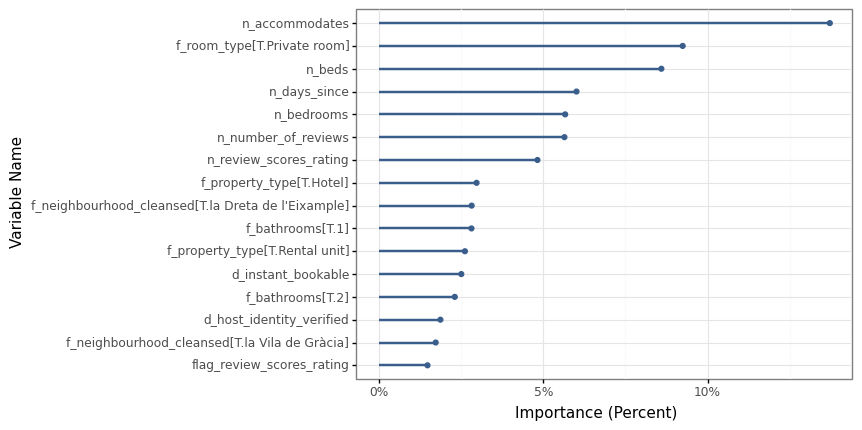

<ggplot: (8766066135739)>

In [726]:
cutoff = 600000

P1 = ggplot(
    rf_model_2_var_imp_df.loc[lambda x: x.imp > cutoff],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), color=color[0], size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()
P1

In [729]:
ggsave(plot = P1, filename="Figure1_A2.png", path = "../Output/")

/Users/chenche/miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/chenche/miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../Output/Figure1_A2.png


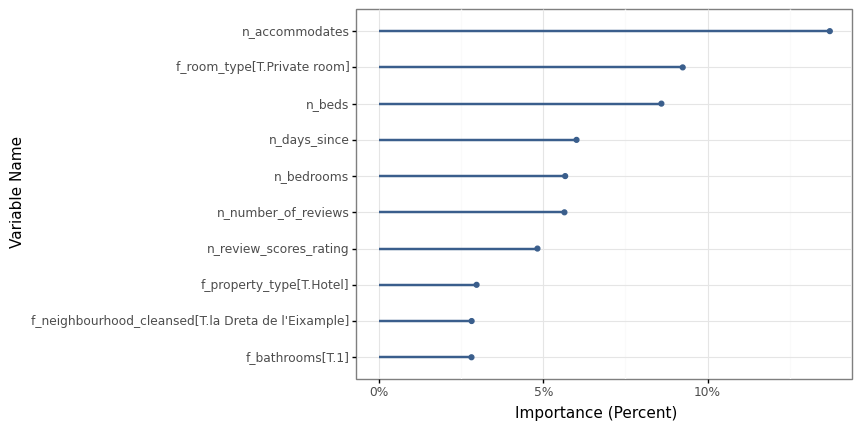

<ggplot: (8765961422894)>

In [731]:
P2 = ggplot(
    rf_model_2_var_imp_df.iloc[:10, :],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), color=color[0], size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()
P2

In [732]:
ggsave(plot = P2, filename="Figure2_A2.png", path = "../Output/")

/Users/chenche/miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/chenche/miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../Output/Figure2_A2.png


In [706]:
categorical_columns = [col for col in Predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in Predictors_2 if col not in categorical_columns]

In [707]:
categorical_columns.remove('f_neighbourhood_cleansed')

In [708]:
categorical_columns.append('f_nbh')

In [709]:
categorical_columns

['f_property_type', 'f_room_type', 'f_bathrooms', 'f_nbh']

In [710]:
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

rf = Pipeline(
    [("preprocess", preprocessing), ("regressor", rf_model_2.best_estimator_)]
)

In [711]:
Predictors_2.remove('f_neighbourhood_cleansed')
Predictors_2.append('f_nbh')

In [712]:
rf.fit(data_train_set[Predictors_2],data_train_set['price'])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_nbh']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_bedrooms', 'n_days_since',
                                                   'n_number_of_reviews',
                                                   'flag_n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'flag_review_scores_rating',
                                                   'd_host_is_super

In [713]:
result = permutation_importance(
    rf,
    data_train_set[Predictors_2],
    data_train_set['price'],
    n_repeats=10,
    random_state=45,
)

In [714]:
grouped = [
    "f_property_type",
    "f_room_type",
    "f_bathrooms",
    "f_nbh",
    "n_days_since",
    "n_accommodates",
    "n_beds",
    "n_bedrooms"
]
grouped_imp = (
    pd.DataFrame(
        result.importances_mean,
        data_train_set[Predictors_2].columns,
    )
    .loc[grouped]
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

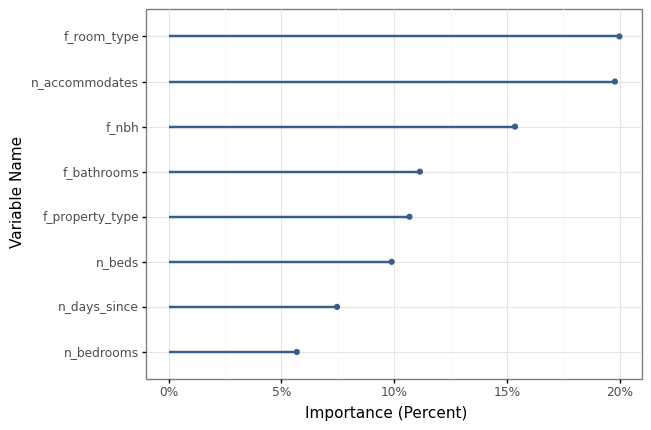

<ggplot: (8765913392125)>

In [733]:
P3 = ggplot(grouped_imp, aes(x="reorder(varname, imp)", y="imp_percentage"),) + geom_point(
    color=color[0], size=1.5
) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), color=color[0], size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()
P3

In [734]:
ggsave(plot = P3, filename="Figure3_A2.png", path = "../Output/")

/Users/chenche/miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/chenche/miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../Output/Figure3_A2.png


***Partial dependence plots***

In [716]:
data_holdout_set.drop('f_neighbourhood_cleansed', axis = 1)
data_holdout_set["f_nbh"]=data_holdout_set.f_neighbourhood_cleansed.apply(lambda x: np.where(x in filt,x,'Other'))

/var/folders/lq/10gdfgyj495gwt01brtf67740000gn/T/ipykernel_71348/3059721298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


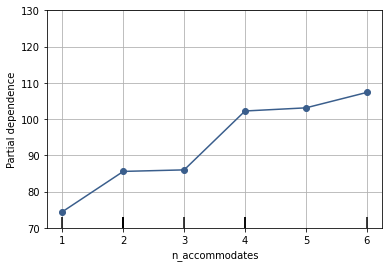

In [738]:
plot_partial_dependence(
    rf,
    data_holdout_set[Predictors_2],
    ["n_accommodates"],
    feature_names = data_holdout_set[Predictors_2].columns,
    line_kw={"marker": "o", "color": color[0]},
)
plt.grid()
plt.ylim(70, 130)
plt.show()

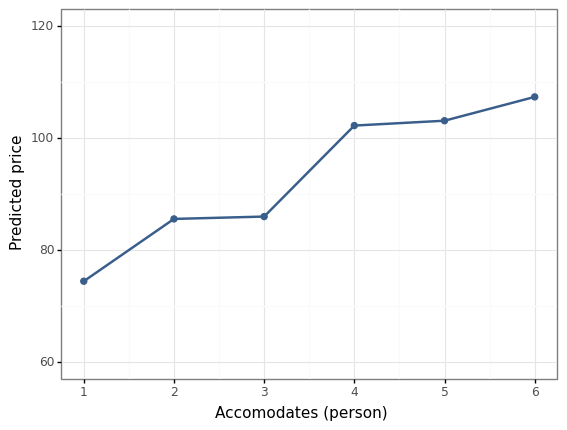

<ggplot: (8765929449198)>

In [739]:
accom_pdp = partial_dependence(
    rf, data_holdout_set[Predictors_2], ["n_accommodates"], kind="average"
)

accom_pdp = (
    pd.DataFrame(accom_pdp["average"], columns=accom_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Accomodates (person)"}, axis=1)
)

ggplot(accom_pdp, aes(x="Accomodates (person)", y="Predicted price")) + geom_point(
    color=color[0], size=2
) + geom_line(color=color[0], size=1) + ylim(60, 120) + scale_x_continuous(
    breaks=range(1, 8)
) + theme_bw()

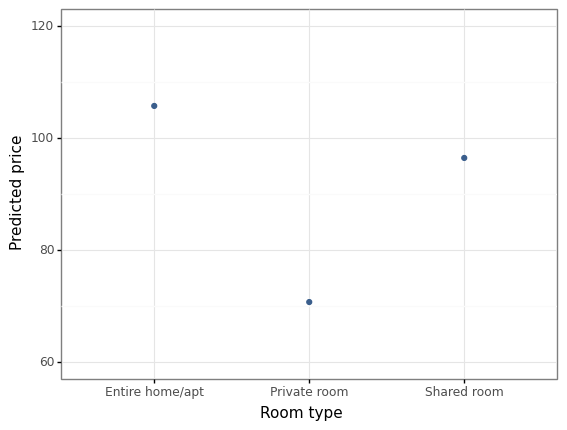

<ggplot: (8766084394478)>

In [740]:
roomtype_pdp = partial_dependence(
    rf, data_holdout_set[Predictors_2], ["f_room_type"], kind="average"
)

roomtype_pdp = (
    pd.DataFrame(roomtype_pdp["average"], columns=roomtype_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Room type"}, axis=1)
)

ggplot(roomtype_pdp, aes(x="Room type", y="Predicted price")) + geom_point(
    color=color[0]
) + ylim(60, 120) + theme_bw()

***CART model***

In [720]:
y, X = dmatrices("price ~ " + " + ".join(Predictors_2), data_train_set)

In [721]:
CART_model = DecisionTreeClassifier(random_state = 2021, criterion = "gini")

*Get potential ccp_alpha parameters*

In [722]:
path = CART_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

*Apply random search to select a "best" alpha*

In [723]:
CART_model_cv = RandomizedSearchCV(
    CART_model,
    {"ccp_alpha":ccp_alphas},
    cv = 5,
    scoring = "neg_root_mean_squared_error",
    verbose = 3,
)


CART_model_cv.fit(X,y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/chenche/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.


[CV 1/5] END .ccp_alpha=9.935419771485345e-05;, score=-88.417 total time=   0.2s
[CV 2/5] END .ccp_alpha=9.935419771485345e-05;, score=-90.716 total time=   0.2s
[CV 3/5] END .ccp_alpha=9.935419771485345e-05;, score=-83.001 total time=   0.2s
[CV 4/5] END .ccp_alpha=9.935419771485345e-05;, score=-89.008 total time=   0.2s
[CV 5/5] END .ccp_alpha=9.935419771485345e-05;, score=-82.979 total time=   0.2s
[CV 1/5] END ccp_alpha=0.00011318275182942063;, score=-88.383 total time=   0.2s
[CV 2/5] END ccp_alpha=0.00011318275182942063;, score=-90.623 total time=   0.2s
[CV 3/5] END ccp_alpha=0.00011318275182942063;, score=-83.059 total time=   0.2s
[CV 4/5] END ccp_alpha=0.00011318275182942063;, score=-88.933 total time=   0.2s
[CV 5/5] END ccp_alpha=0.00011318275182942063;, score=-83.086 total time=   0.2s
[CV 1/5] END .ccp_alpha=9.935419771485345e-05;, score=-88.417 total time=   0.2s
[CV 2/5] END .ccp_alpha=9.935419771485345e-05;, score=-90.716 total time=   0.2s
[CV 3/5] END .ccp_alpha=9.93

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2021),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 6.62361318e-06, 6.62361318e-06, ...,
       1.57911547e-03, 1.82409218e-03, 4.08957529e-03])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [724]:
CART_rmse = pd.DataFrame(CART_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == CART_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
CART_rmse

85.16927596361315

In [725]:
np.save("../Output/bcn_CART.npy", CART_rmse)